# Extract from TMDB

**Your stakeholder wants you to extract the budget, revenue, and MPAA Rating (G/PG/PG-13/R), which is also called "Certification".**


## Imports/Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import json, os, time, math
import tmdbsimple as tmdb

from tqdm.notebook import tqdm_notebook

pd.set_option('display.max_columns',50)
pd.set_option('display.max_rows',50)

In [2]:
!pip install tmdbsimple

In [3]:
#create folder for saving files(if it doesnt exist)
FOLDER = 'Data/'
os.makedirs(FOLDER, exist_ok=True)
os.listdir(FOLDER)

['tmdb_api_2001.json',
 '.DS_Store',
 'FINAL_title_basics.csv',
 'tmdb_api_COMBINED_2002.csv.gz',
 'FINAL_title_ratings.csv',
 'title-akas-us-only.csv',
 '.ipynb_checkpoints',
 'tmdb_api_data.csv',
 'tmdb_api_COMBINED_2001.csv.gz',
 'Raw Data',
 'tmdb_api_2002.json',
 'SQL']

## API Connection

In [4]:
with open('/Users/jeffrey/.secret/tmdb_api.json', 'r') as f:
    login = json.load(f)

login.keys()

dict_keys(['api-key'])

In [5]:
tmdb.API_KEY = login['api-key']

## Functions

In [6]:
def get_movie_with_ratings(movie_id):
    #Adapted from source - https://gihub.com/celia/tmdbsimple
    #movie object for id selected
    movie = tmdb.Movies(movie_id)
    #save info & releases
    info = movie.info()

    releases = movie.releases()
    #loop: countries in the releases info
    for c in releases['countries']:
        if c['iso_3166_1'] == 'US':
            info['certification'] = c['certification']
    return info

In [7]:
#appends list o records to json file
def write_json(new_data, filename):
    with open(filename, 'r+') as file:
        file_data = json.load(file)
        if (type(new_data) == list) & (type(file_data) == list):
            file_data.extend(new_data)
        else:
            file_data.append(new_data)

        file.seek(0)
        json.dump(file_data, file)

# Extract - Financial Data

In [8]:
basics = pd.read_csv('Data/FINAL_title_basics.csv')
basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001.0,NaN,118,"Comedy,Fantasy,Romance"
1,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El tango del viudo y su espejo deformante,0,2020.0,NaN,70,Drama
2,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018.0,NaN,122,Drama
3,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005.0,NaN,100,"Comedy,Horror,Sci-Fi"
4,tt0096056,movie,Crime and Punishment,Crime and Punishment,0,2002.0,NaN,126,Drama


## Loop: Extract Data from API / Store in File

In [9]:
#variable to test and hold errors
YEARS_TO_GET = [2001, 2002]
errors = []

In [10]:
#Start OUTER Loop
for YEAR in tqdm_notebook(YEARS_TO_GET, desc='YEARS', position=0):
    #Create JSON for storage of results
    JSON_FILE = f'{FOLDER}tmdb_api_{YEAR}.json'
    file_exists = os.path.isfile(JSON_FILE)

    #Create Loop for if file doesnt exist
    if file_exists == False:
        print(f"Creating {JSON_FILE} for {YEAR}.")
    #save empty dict to hold imdb_id
        with open(JSON_FILE, 'w') as f:
            json.dump([{'imdb_id':0}],f)

    df = basics.loc[basics['startYear'] == YEAR].copy()
    movie_ids = df['tconst'].copy()
    movie_ids

    old_df = pd.read_json(JSON_FILE)
    old_df

    movie_ids_to_get = movie_ids[~movie_ids.isin(old_df['imdb_id'])]
    for movie_id in tqdm_notebook(movie_ids_to_get, f"Movies from {YEAR}", position = 1, leave=True):
        try:
            temp = get_movie_with_ratings(movie_id)
            write_json(temp, JSON_FILE)
            time.sleep(.02)

        except Exception as e:
            errors.append([YEARS_TO_GET, e])
            continue

    final_year_df = pd.read_json(JSON_FILE)
    final_year_df.to_csv(f"{FOLDER}tmdb_api_COMBINED_{YEAR}.csv.gz", compression="gzip", index=False)

YEARS:   0%|          | 0/2 [00:00<?, ?it/s]

Movies from 2001:   0%|          | 0/224 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
print (f" - Total erros: {len(errors)}")b

In [ ]:
final_year_df.head()

### Compile/Save Data

In [ ]:
import glob

tmdb_files = sorted(glob.glob("Data/tmdb_api*.csv.gz"))
tmdb_files

In [ ]:
df = pd.concat([pd.read_csv(f) for f in tmdb_files])
df.head()

In [ ]:
df.to_csv('Data/tmdb_api_data.csv')

# Exploratory Data Analysis

## DataFrame Explorations:

In [11]:
df = pd.read_csv('Data/tmdb_api_data.csv')

In [12]:
df.head()

,Unnamed: 0,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,tt0035423,0.0,/tJLV3BAlHOgscVOrA99Wnb2gAef.jpg,NaN,48000000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 14, ...",NaN,11232.0,en,Kate & Leopold,When her scientist ex-boyfriend discovers a po...,12.705,/mUvikzKJJSg9khrVdxK8kg3TMHA.jpg,"[{'id': 85, 'logo_path': None, 'name': 'Konrad...","[{'iso_3166_1': 'US', 'name': 'United States o...",2001-12-25,76019048.0,118.0,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,"If they lived in the same century, they'd be p...",Kate & Leopold,0.0,6.325,1234.0,PG-13
2,2,tt0114447,0.0,NaN,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...",NaN,151007.0,en,The Silent Force,An elite Federal force whose objective is to e...,3.773,/u0njmfXD3dXxQfeykBHBuFQOYqD.jpg,[],[],2001-01-01,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,They left him for dead... They should have fin...,The Silent Force,0.0,5.000,3.0,NaN
3,3,tt0116916,0.0,/rFpHBidSlhjflmnLu7BZilyKeQR.jpg,NaN,0.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,73549.0,en,The Dark Mist,With the future of the world hanging in the ba...,1.400,/z18E0lukzOtAALmfINSTCUU0Als.jpg,"[{'id': 71364, 'logo_path': None, 'name': 'Car...","[{'iso_3166_1': 'US', 'name': 'United States o...",1996-01-01,0.0,101.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,The Dark Mist,0.0,3.500,2.0,PG
4,4,tt0118589,0.0,/9NZAirJahVilTiDNCHLFcdkwkiy.jpg,NaN,22000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...",NaN,10696.0,en,Glitter,"A young woman is catapulted into pop stardom, ...",11.213,/b8gKsXB6d60SC2HKUcAAzTacn0S.jpg,"[{'id': 89627, 'logo_path': None, 'name': 'Gli...","[{'iso_3166_1': 'US', 'name': 'United States o...",2001-09-21,5271666.0,104.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,"In music she found her dream, her love, herself.",Glitter,0.0,4.405,132.0,PG-13


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2645 entries, 0 to 2644
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             2645 non-null   int64  
 1   imdb_id                2645 non-null   object 
 2   adult                  2643 non-null   float64
 3   backdrop_path          1516 non-null   object 
 4   belongs_to_collection  215 non-null    object 
 5   budget                 2643 non-null   float64
 6   genres                 2643 non-null   object 
 7   homepage               212 non-null    object 
 8   id                     2643 non-null   float64
 9   original_language      2643 non-null   object 
 10  original_title         2643 non-null   object 
 11  overview               2585 non-null   object 
 12  popularity             2643 non-null   float64
 13  poster_path            2404 non-null   object 
 14  production_companies   2643 non-null   object 
 15  prod

In [14]:
df.shape

(2645, 27)

## Visualization 1:

How many movies had at least some valid financial information (values > 0 for budget OR revenue)?
Please exclude any movies with 0's for budget AND revenue from the remaining visualizations.

In [62]:
test = df.copy()
test.head()

,Unnamed: 0,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,tt0035423,0.0,/tJLV3BAlHOgscVOrA99Wnb2gAef.jpg,NaN,48000000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 14, ...",NaN,11232.0,en,Kate & Leopold,When her scientist ex-boyfriend discovers a po...,12.705,/mUvikzKJJSg9khrVdxK8kg3TMHA.jpg,"[{'id': 85, 'logo_path': None, 'name': 'Konrad...","[{'iso_3166_1': 'US', 'name': 'United States o...",2001-12-25,76019048.0,118.0,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,"If they lived in the same century, they'd be p...",Kate & Leopold,0.0,6.325,1234.0,PG-13
2,2,tt0114447,0.0,NaN,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...",NaN,151007.0,en,The Silent Force,An elite Federal force whose objective is to e...,3.773,/u0njmfXD3dXxQfeykBHBuFQOYqD.jpg,[],[],2001-01-01,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,They left him for dead... They should have fin...,The Silent Force,0.0,5.000,3.0,NaN
3,3,tt0116916,0.0,/rFpHBidSlhjflmnLu7BZilyKeQR.jpg,NaN,0.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,73549.0,en,The Dark Mist,With the future of the world hanging in the ba...,1.400,/z18E0lukzOtAALmfINSTCUU0Als.jpg,"[{'id': 71364, 'logo_path': None, 'name': 'Car...","[{'iso_3166_1': 'US', 'name': 'United States o...",1996-01-01,0.0,101.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,The Dark Mist,0.0,3.500,2.0,PG
4,4,tt0118589,0.0,/9NZAirJahVilTiDNCHLFcdkwkiy.jpg,NaN,22000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...",NaN,10696.0,en,Glitter,"A young woman is catapulted into pop stardom, ...",11.213,/b8gKsXB6d60SC2HKUcAAzTacn0S.jpg,"[{'id': 89627, 'logo_path': None, 'name': 'Gli...","[{'iso_3166_1': 'US', 'name': 'United States o...",2001-09-21,5271666.0,104.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,"In music she found her dream, her love, herself.",Glitter,0.0,4.405,132.0,PG-13


In [63]:
test['budget'].value_counts()

0.0           2027
3000000.0       20
4000000.0       19
35000000.0      17
25000000.0      16
              ... 
165000.0         1
5500000.0        1
19800000.0       1
9400000.0        1
1000.0           1
Name: budget, Length: 197, dtype: int64

In [64]:
test['revenue'].value_counts()

0.0            2126
6000000.0         3
500000.0          2
12000000.0        2
6500000.0         2
               ... 
33788161.0        1
100020092.0       1
100420.0          1
306737.0          1
2000000.0         1
Name: revenue, Length: 512, dtype: int64

In [65]:
result = (test['budget'] != 0) | (test['revenue'] != 0)
result.value_counts()

False    1917
True      728
dtype: int64

There are 728 movies with information for EITHER budget or revenue. Leaving 1917 without information in either column.

In [66]:
# Count rows with 0 in both 'budget' and 'revenue'
count_both_zero = len(test[(test['budget'] == 0) & (test['revenue'] == 0)])

# Display the count
print("Number of rows with 0 in both 'budget' and 'revenue':", count_both_zero)

Number of rows with 0 in both 'budget' and 'revenue': 1917


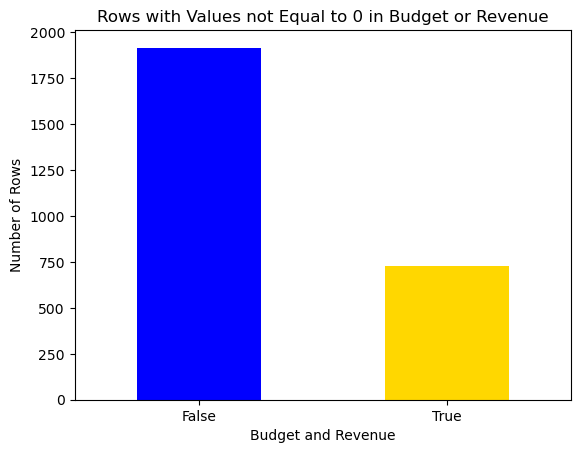

In [69]:
mask = (test['budget'] != 0) | (test['revenue'] != 0)

counts = mask.value_counts()
colors = ['blue', 'gold']

# Create a bar chart (histogram) to visualize the counts
counts.plot(kind='bar', rot=0, color=colors)
plt.xlabel('Budget and Revenue')
plt.ylabel('Number of Rows')
plt.title('Rows with Values not Equal to 0 in Budget or Revenue')

plt.show()

In [70]:
test = test[(test['budget'] != 0) | (test['revenue'] != 0)]
test.shape

(728, 27)

## Vizualization 2:
How many movies are there in each of the certification categories (G/PG/PG-13/R)?

Text(0.5, 1.0, 'Movies by Certification Category')

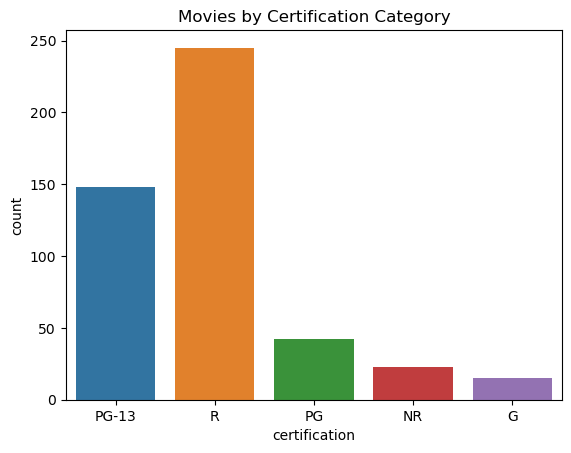

In [72]:
ax = sns.countplot(data=test, x='certification')
ax.set_title('Movies by Certification Category')

## Vizualization 3:

What is the average revenue per certification category?

Text(0.5, 1.0, 'Average Revenue by Certification Category')

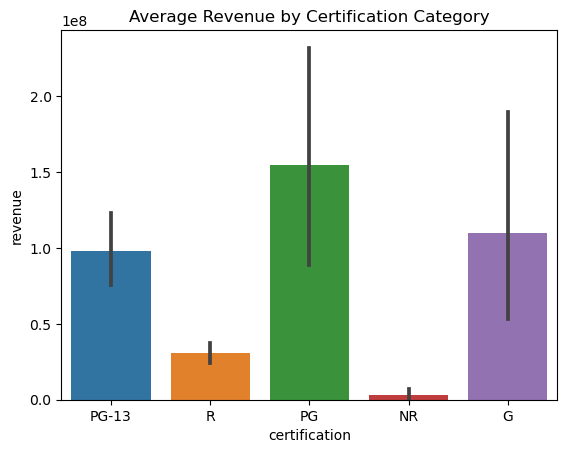

In [76]:
ax = sns.barplot(data=test, x='certification', y='revenue')
ax.set_title('Average Revenue by Certification Category')

## Vizualization 4:

What is the average budget per certification category?

Text(0.5, 1.0, 'Average Budget by Certification Category')

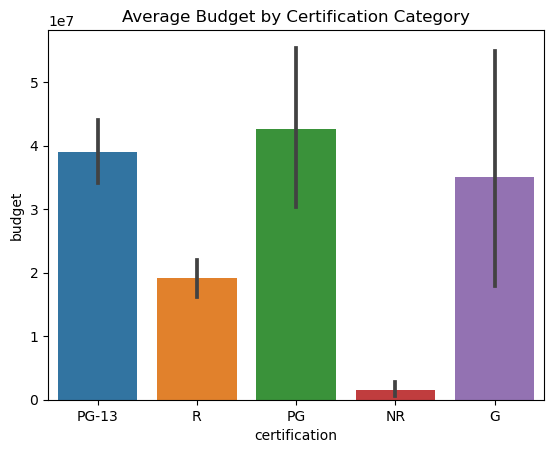

In [77]:
ax = sns.barplot(data=test, x='certification', y='budget')
ax.set_title('Average Budget by Certification Category')